# Logistic Regression on BRCA subset of the TCGA dataset
#### Using Logistic Regression for breast cancer subtype classification

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt

## Load and split the dataset

In [2]:
# Training set
X_train = pd.read_pickle("../data/tcga_brca_raw_19036_row_log_norm_train.pkl")
y_train = X_train["Ciriello_subtype"]
X_train.drop(['tcga_id', 'Ciriello_subtype', 'sample_id', 'cancer_type'], axis="columns", inplace=True)

# Final test set
X_test = pd.read_pickle("../data/tcga_brca_raw_19036_row_log_norm_test.pkl")
y_test = X_test["subtype"]
X_test.drop(['tcga_id', 'subtype', 'sample_id', 'cancer_type'], axis="columns", inplace=True)

# Order the features correctly

X_train = X_train.reindex(sorted(X_train.columns), axis="columns")
X_test = X_test.reindex(sorted(X_test.columns), axis="columns")

In [3]:
X_train.shape

(817, 19036)

In [4]:
X_test.shape

(236, 19036)

### Scale the data

In [5]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [9]:
genes = X_train.columns.values

In [188]:
genes[genes=="KRT17"]

array(['KRT17'], dtype=object)

## Code to tune parameter C

In [6]:
values=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
i=1
results = pd.DataFrame(columns=["Index", "C", "Accuracy"])
mean_scores = []

skf = StratifiedKFold(n_splits=5, shuffle=True)
for c in values:
    scores = []

    for train_index, test_index in skf.split(X_train_scaled, y_train):

        X_cv_train, X_cv_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
        y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

        clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=c, multi_class="auto").fit(X_cv_train, y_cv_train)

        score = clf.score(X_cv_val, y_cv_val)
        results = results.append({'Fold': i, 'C' : c , 'Score' : score}, ignore_index=True)
        scores.append(score)
        i+=1

    i=1
    mean_scores.append(np.mean(scores))
    print('Results: {}'.format(scores))
    print('C: {}, Accuracy: {}'.format(c, np.mean(scores)))

#results.to_csv("parameter_tuning/LogisticRegression/tcga_c_tuning_all_genes.csv", index=False)
mean_scores

Results: [0.1696969696969697, 0.1656441717791411, 0.1656441717791411, 0.1656441717791411, 0.1656441717791411]
C: 0.001, Accuracy: 0.1664547313627068
Results: [0.503030303030303, 0.50920245398773, 0.5153374233128835, 0.50920245398773, 0.50920245398773]
C: 0.01, Accuracy: 0.5091950176612754
Results: [0.8, 0.7975460122699386, 0.7975460122699386, 0.7852760736196319, 0.803680981595092]
C: 0.1, Accuracy: 0.7968098159509202
Results: [0.8545454545454545, 0.9079754601226994, 0.8957055214723927, 0.8404907975460123, 0.8773006134969326]
C: 1, Accuracy: 0.8752035694366983
Results: [0.9272727272727272, 0.8711656441717791, 0.852760736196319, 0.8895705521472392, 0.8773006134969326]
C: 10, Accuracy: 0.8836140546569993
Results: [0.8787878787878788, 0.8895705521472392, 0.8895705521472392, 0.8834355828220859, 0.8159509202453987]
C: 100, Accuracy: 0.8714630972299684
Results: [0.8303030303030303, 0.8159509202453987, 0.8834355828220859, 0.8588957055214724, 0.8957055214723927]
C: 1000, Accuracy: 0.85685815207

[0.1664547313627068,
 0.5091950176612754,
 0.7968098159509202,
 0.8752035694366983,
 0.8836140546569993,
 0.8714630972299684,
 0.856858152072876,
 0.8409221044803866]

### We can see that C=10 is the best parameter, hence why we'll use it to test our model

In [10]:
clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=10, multi_class="auto").fit(X_train_scaled, y_train)

In [11]:
final_score = clf.score(X_test_scaled, y_test)
print('Confusion matrix\n', confusion_matrix(y_test, clf.predict(X_test_scaled)))
print('Accuracy', final_score)

Confusion matrix
 [[ 43   0   0   0   0]
 [  0  14   1   1   0]
 [  0   1 125   5   0]
 [  0   0   3  29   0]
 [  0   2   5   1   6]]
Accuracy 0.9194915254237288


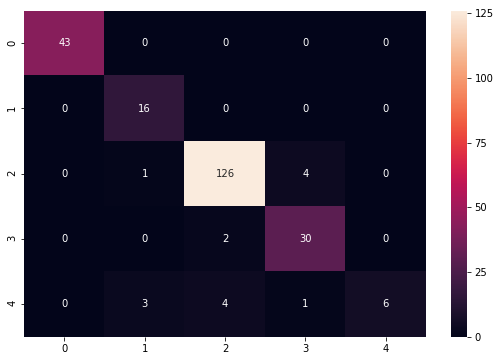

In [9]:
import matplotlib.pyplot as plt
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test_scaled)))
plt.figure(figsize=(9, 6))
sn.heatmap(conf_matrix, annot=True, fmt='g')
#conf_matrix.to_csv("results/LogisticRegression/tcga_confusion_matrix_all_genes.csv")

In [12]:
y_test.value_counts()

LumA      131
Basal      43
LumB       32
Her2       16
Normal     14
Name: subtype, dtype: int64

# Relevant gene analysis

In [32]:
print("First class has {} genes counting".format(len(clf.coef_[0][clf.coef_[0]!=0])))
rel_genes_1 = genes[clf.coef_[0]!=0]
print("Second class has {} genes counting".format(len(clf.coef_[1][clf.coef_[1]!=0])))
rel_genes_2 = genes[clf.coef_[1]!=0]
print("Third class has {} genes counting".format(len(clf.coef_[2][clf.coef_[2]!=0])))
rel_genes_3 = genes[clf.coef_[2]!=0]
print("Fourth class has {} genes counting".format(len(clf.coef_[3][clf.coef_[3]!=0])))
rel_genes_4 = genes[clf.coef_[3]!=0]
print("Fifth class has {} genes counting".format(len(clf.coef_[4][clf.coef_[4]!=0])))
rel_genes_5 = genes[clf.coef_[4]!=0]

First class has 501 genes counting
Second class has 390 genes counting
Third class has 716 genes counting
Fourth class has 973 genes counting
Fifth class has 371 genes counting


In [36]:
int_1_2 = np.intersect1d(rel_genes_1, rel_genes_2)

In [39]:
int_1_2_3 = np.intersect1d(int_1_2, rel_genes_3)

In [40]:
int_1_2_3_4 = np.intersect1d(int_1_2_3, rel_genes_4)

In [42]:
int_1_2_3_4_5 = np.intersect1d(int_1_2_3_4, rel_genes_5)

In [44]:
int_1_2_3_4_5

array([], dtype=object)

### We can see that no genes are relevant for all five subtypes, curious result

In [178]:
sort_idx_1 = np.argsort(abs(clf.coef_[0]))

In [77]:
sort_idx_1[-50:]

array([ 4219,  4187,  8492,  4009, 11987, 13531,  5703,  5506,  2700,
       14988,  5481,  5616, 12148, 12731,  5774,  3087, 12479,  5368,
        3244,  3674,  1486, 13400, 18665,  1845, 15665, 16142,  2539,
          60,  2701,  5512, 18111,   544,  6949, 10193,  5614,  3477,
       17292, 18339, 14936, 14584,  6064,  5961,  7780,  3242, 11469,
        8533,  9474, 12553, 11867,  6615])

#### 50 most influential genes subtype 1

In [79]:
inf_50_genes_1 = genes[sort_idx_1[-50:]]

In [80]:
inf_50_genes_1_weight = clf.coef_[0][sort_idx_1[-50:]]

In [81]:
inf_50_genes_1_weight

array([ 0.38284384, -0.38317208,  0.38518425, -0.39008018, -0.39283577,
        0.40449903,  0.40643476, -0.41615543, -0.41790692,  0.42697358,
        0.43359262,  0.43894812, -0.44335229, -0.44499843,  0.45533633,
        0.46544131,  0.49133587,  0.49319611,  0.4961675 , -0.49681531,
       -0.49796291,  0.49807067,  0.49909697,  0.50284445,  0.52182609,
        0.53452794, -0.53681855, -0.53724366, -0.56908247,  0.60202882,
        0.60622812, -0.61263355, -0.64415628, -0.68214514,  0.73003913,
        0.76440591, -0.76684331, -0.8062482 , -0.81331164, -0.82155902,
        0.82720705,  0.83408763,  0.86125049,  0.87483953, -0.88891323,
        1.02703965,  1.09203949,  1.50988111,  1.69540619, -1.8974185 ])

#### 50 most influential genes subtype 2

In [84]:
sort_idx_2 = np.argsort(abs(clf.coef_[1]))
inf_50_genes_2 = genes[sort_idx_2[-50:]]
inf_50_genes_2_weight = clf.coef_[1][sort_idx_2[-50:]]

In [85]:
inf_50_genes_2_weight

array([ 0.62375993,  0.64982416, -0.65042196,  0.66327335, -0.66693783,
       -0.68602131, -0.68984713,  0.69532513, -0.70330337, -0.70805113,
        0.71928692, -0.72927569, -0.74805026, -0.75836411, -0.75883276,
        0.76139545,  0.77654552, -0.77777629, -0.79941115, -0.803972  ,
       -0.80678173, -0.81359254, -0.82094016, -0.83816818, -0.84069832,
       -0.84349438, -0.85155786, -0.86183159,  0.86776706, -0.89690662,
        0.90531276,  0.91382624,  0.91723649, -0.92151206,  0.93780465,
        1.00174363,  1.00437826,  1.00467955, -1.02078365, -1.03442023,
        1.11389063, -1.14108379, -1.26531742, -1.27843716,  1.3754982 ,
        1.38840219,  1.48877505,  1.53655474, -1.62708643, -2.04145888])

#### 50 most influential genes subtype 3

In [170]:
sort_idx_3 = np.argsort(abs(clf.coef_[2]))
inf_50_genes_3 = genes[sort_idx_3[-50:]]
inf_50_genes_3_weight = clf.coef_[2][sort_idx_3[-50:]]

#### 50 most influential genes subtype 4

In [171]:
sort_idx_4 = np.argsort(abs(clf.coef_[3]))
inf_50_genes_4 = genes[sort_idx_3[-50:]]
inf_50_genes_4_weight = clf.coef_[3][sort_idx_4[-50:]]

#### 50 most influential genes subtype 5

In [172]:
sort_idx_5 = np.argsort(abs(clf.coef_[4]))
inf_50_genes_5 = genes[sort_idx_5[-50:]]
inf_50_genes_5_weight = clf.coef_[4][sort_idx_5[-50:]]

### Plot weights top 500 subtype 1 - Basal

In [179]:
data_exp = clf.coef_[0][sort_idx_1][-500:]
data_exp_2 = abs(clf.coef_[0][sort_idx_1][-100:])

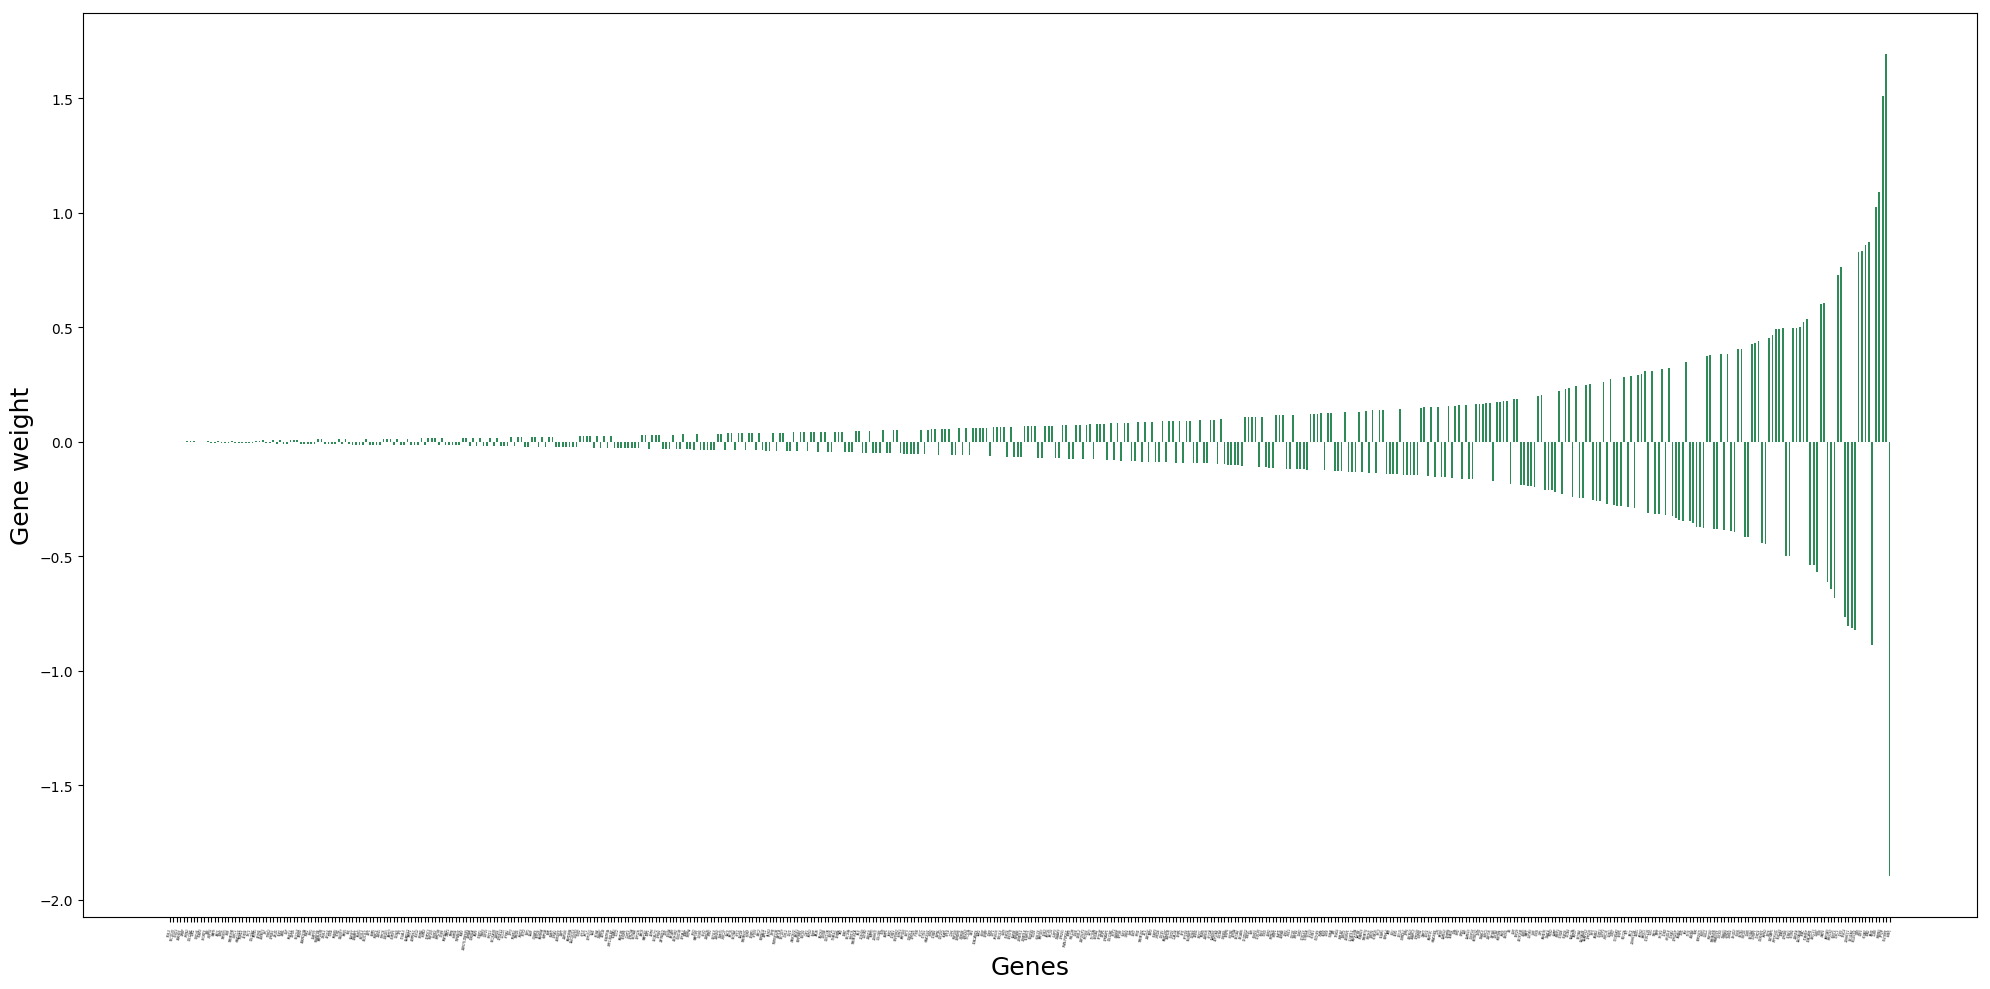

In [180]:
fig = plt.figure(figsize = (20,10))
plt.style.use('default')
ax = fig.add_subplot(111)
xs = np.arange(500)
plt.bar(x=xs, height=data_exp, color="seagreen", width=0.5)
ax.set_ylabel('Gene weight', fontsize=18)
ax.set_xlabel('Genes', fontsize=18)
plt.xticks(xs, genes[sort_idx_1][-500:])
ax.tick_params(axis='x', labelsize=2, labelrotation=80)
fig.tight_layout()
plt.savefig('../figures/top_features_log_res_basal.pdf', bbox_inches='tight')

### Plot weights top 500 subtype 2 - HER2

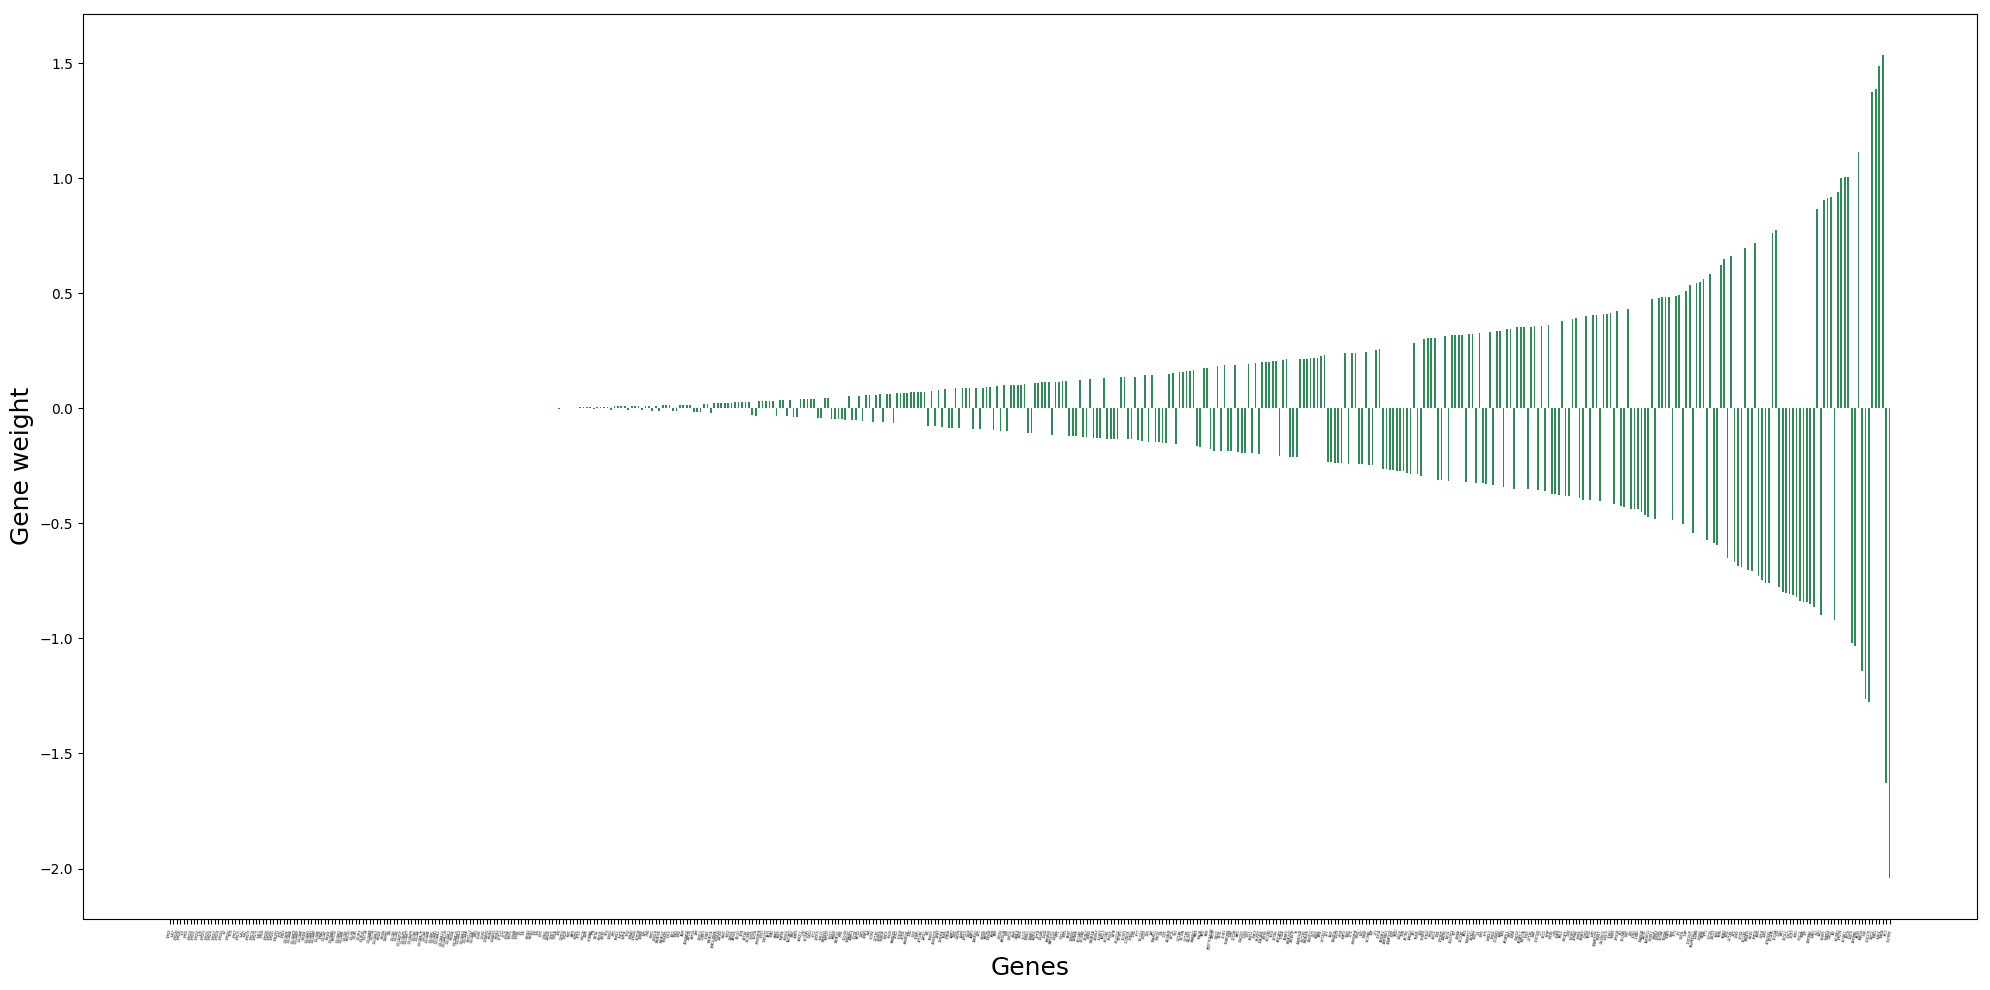

In [181]:
data_exp = clf.coef_[1][sort_idx_2][-500:]
data_exp_2 = abs(clf.coef_[1][sort_idx_2][-500:])

fig = plt.figure(figsize = (20,10))
plt.style.use('default')
ax = fig.add_subplot(111)
xs = np.arange(500)
plt.bar(x=xs, height=data_exp, color="seagreen", width=0.5)
ax.set_ylabel('Gene weight', fontsize=18)
ax.set_xlabel('Genes', fontsize=18)
plt.xticks(xs, genes[sort_idx_2][-500:])
ax.tick_params(axis='x', labelsize=2, labelrotation=80)
fig.tight_layout()
plt.savefig('../figures/top_features_log_res_her2.pdf', bbox_inches='tight')

### Plot weights top 500 subtype 3 - LumA

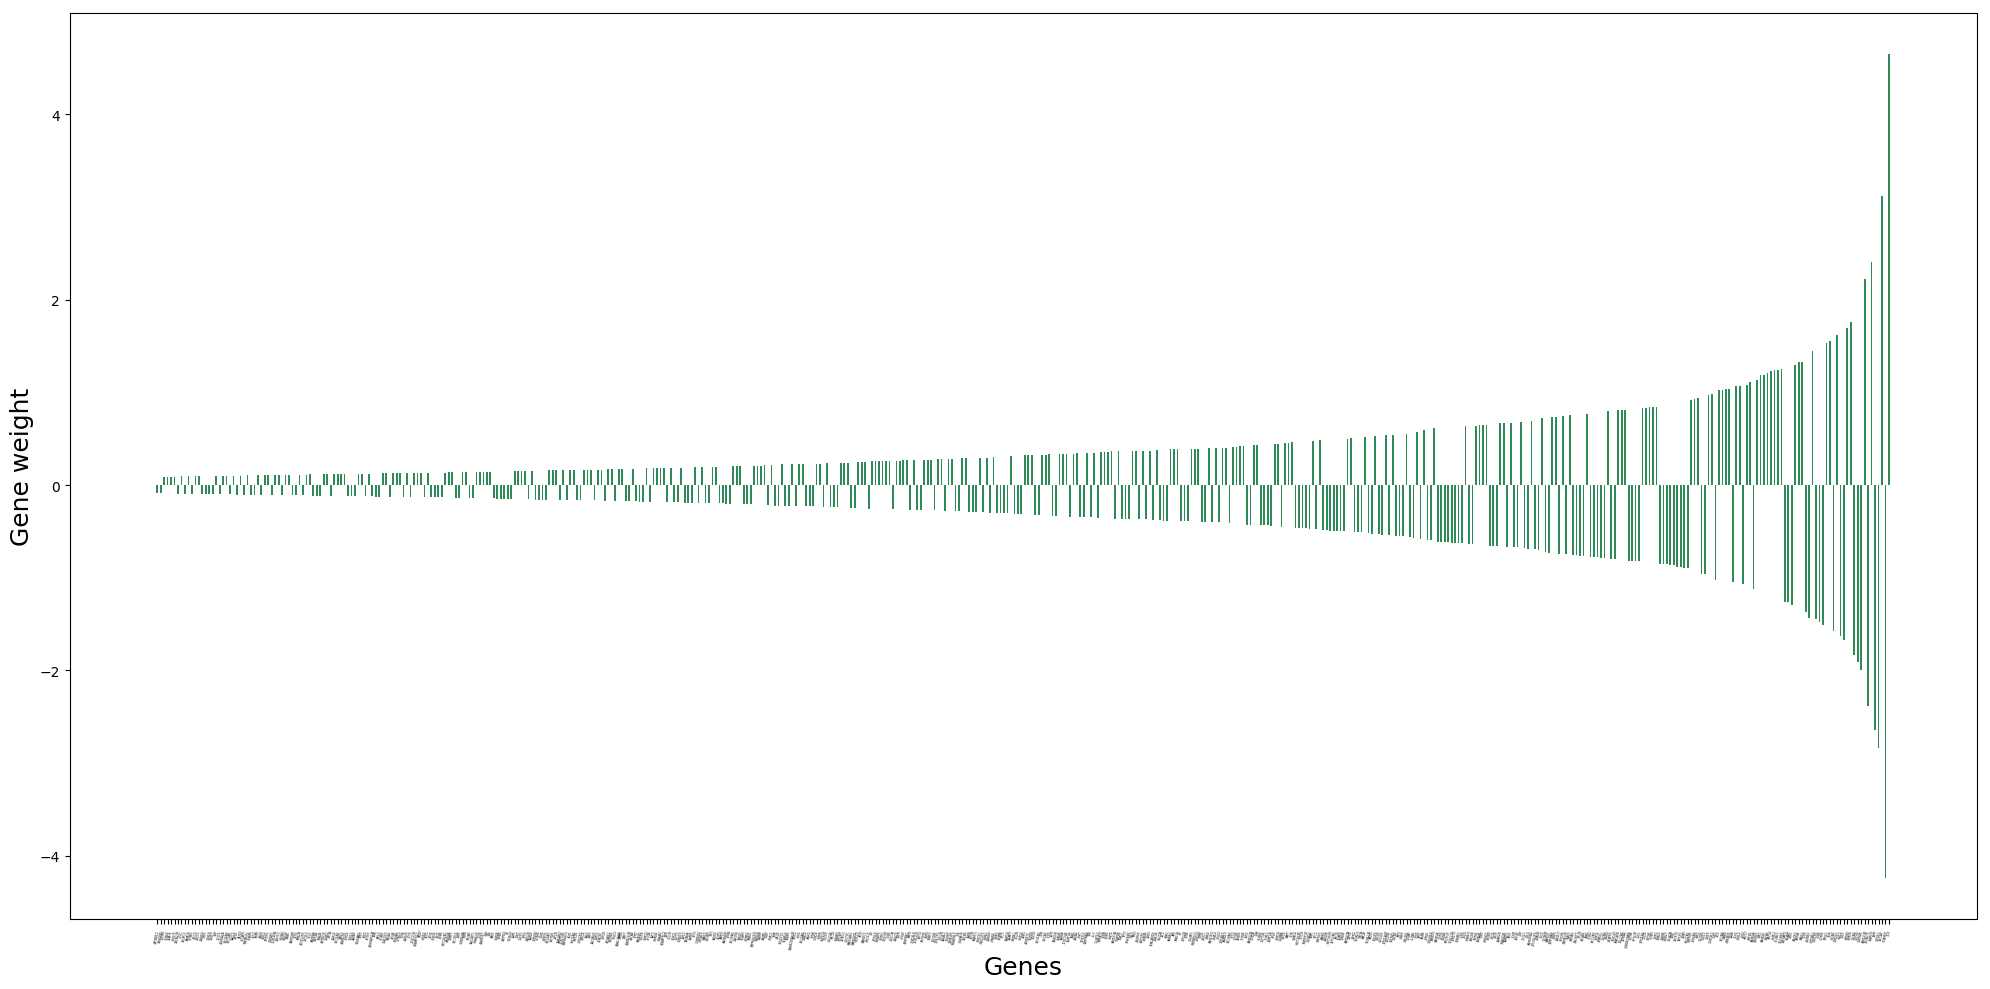

In [182]:
data_exp = clf.coef_[2][sort_idx_3][-500:]
data_exp_2 = abs(clf.coef_[2][sort_idx_3][-500:])

fig = plt.figure(figsize = (20,10))
plt.style.use('default')
ax = fig.add_subplot(111)
xs = np.arange(500)
plt.bar(x=xs, height=data_exp, color="seagreen", width=0.5)
ax.set_ylabel('Gene weight', fontsize=18)
ax.set_xlabel('Genes', fontsize=18)
plt.xticks(xs, genes[sort_idx_3][-500:])
ax.tick_params(axis='x', labelsize=2, labelrotation=80)
fig.tight_layout()
plt.savefig('../figures/top_features_log_res_lumA.pdf', bbox_inches='tight')

### Plot weights top 500 subtype 4 - LumB

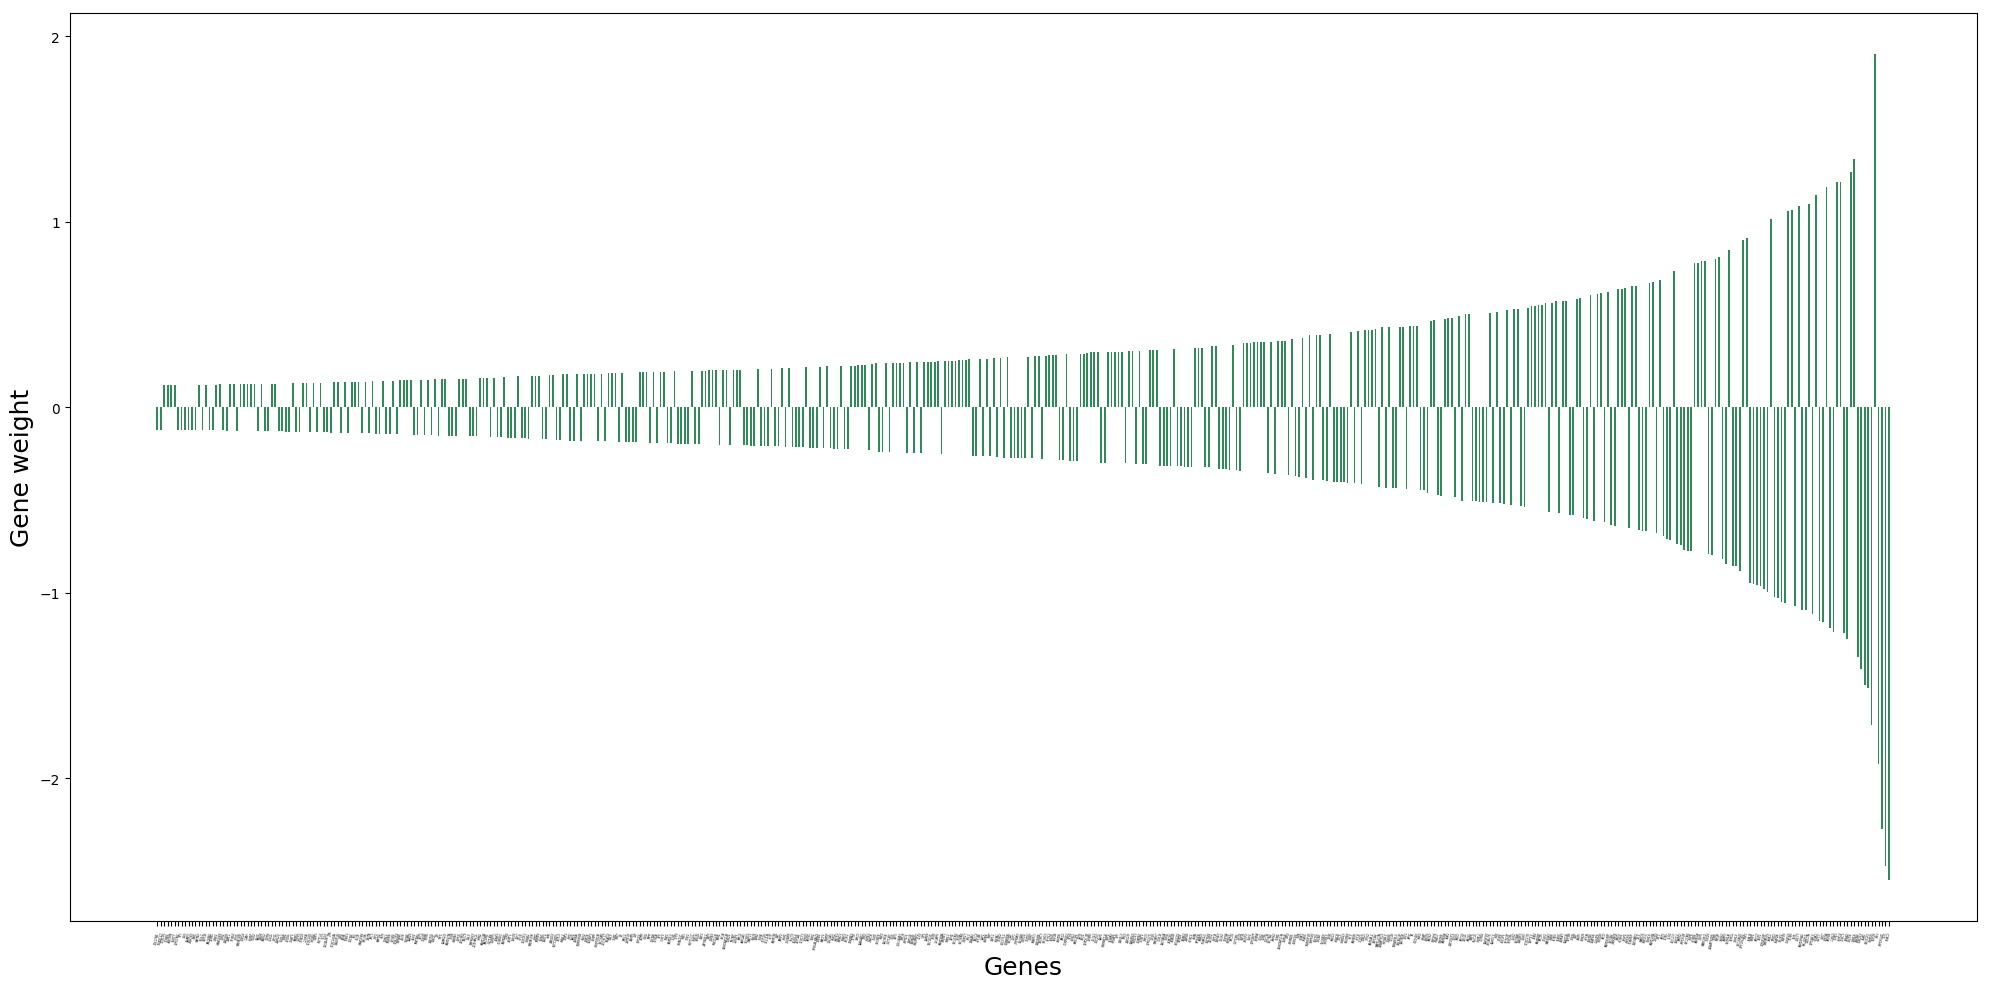

In [183]:
data_exp = clf.coef_[3][sort_idx_4][-500:]
data_exp_2 = abs(clf.coef_[3][sort_idx_4][-500:])

fig = plt.figure(figsize = (20,10))
plt.style.use('default')
ax = fig.add_subplot(111)
xs = np.arange(500)
plt.bar(x=xs, height=data_exp, color="seagreen", width=0.5)
ax.set_ylabel('Gene weight', fontsize=18)
ax.set_xlabel('Genes', fontsize=18)
plt.xticks(xs, genes[sort_idx_4][-500:])
ax.tick_params(axis='x', labelsize=2, labelrotation=80)
fig.tight_layout()
plt.savefig('../figures/top_features_log_res_lumB.pdf', bbox_inches='tight')

### Plot weights top 500 subtype 5 - Normal

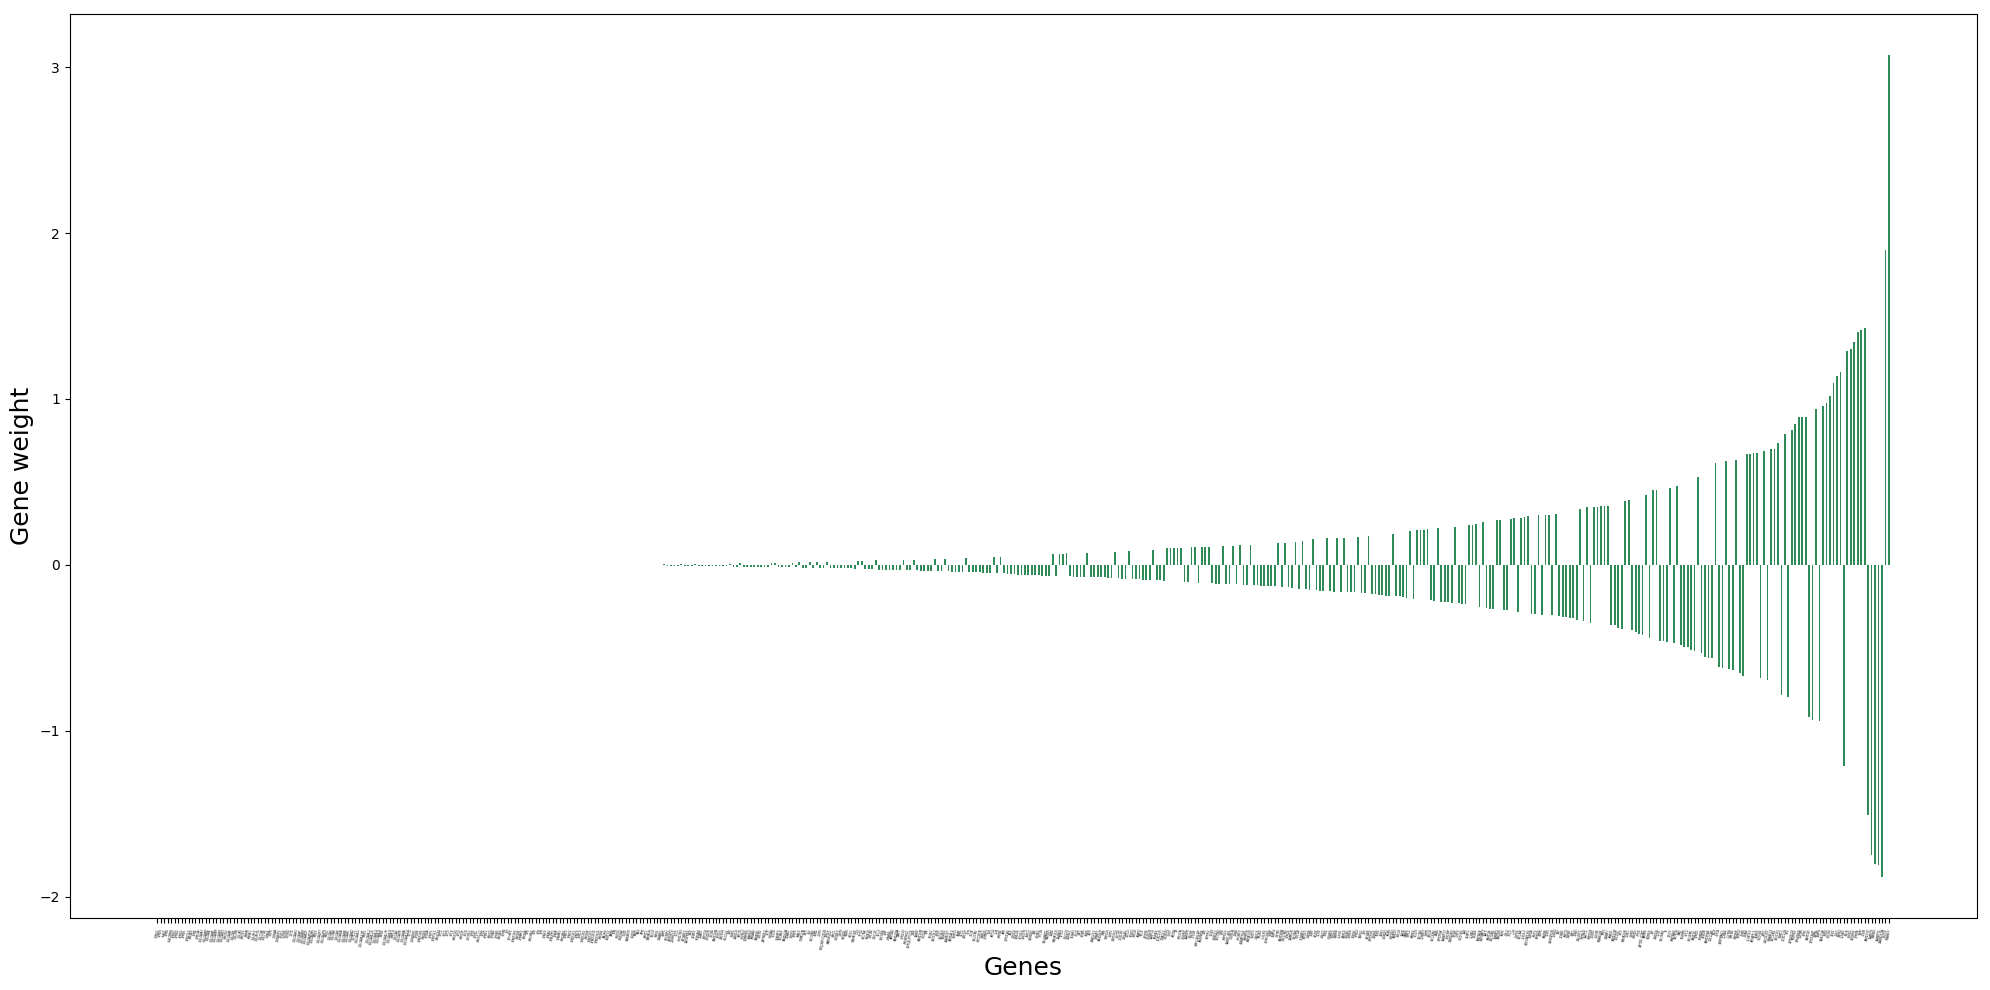

In [184]:
data_exp = clf.coef_[4][sort_idx_5][-500:]
data_exp_2 = abs(clf.coef_[4][sort_idx_5][-500:])

fig = plt.figure(figsize = (20,10))
plt.style.use('default')
ax = fig.add_subplot(111)
xs = np.arange(500)
plt.bar(x=xs, height=data_exp, color="seagreen", width=0.5)
ax.set_ylabel('Gene weight', fontsize=18)
ax.set_xlabel('Genes', fontsize=18)
plt.xticks(xs, genes[sort_idx_5][-500:])
ax.tick_params(axis='x', labelsize=2, labelrotation=80)
fig.tight_layout()
plt.savefig('../figures/top_features_log_res_normal.pdf', bbox_inches='tight')

### Check for overlaps with PAM50 genes

In [194]:
pam50_genes = ["MIA", "SFRP1", "KRT14", "KRT17", "KRT5", "FGFR4", "GRB7", "ERBB2", "BAG1", "MDM2", "ACTR3B", "BLVRA", "CXXC5", "TMEM45B", "MMP11", "FOXC1", "EGFR", "CDH3", "PHGDH", "MYC", "CCNE1" ,"CDCA1", "CDC20", "KIF2C", "TYMS", "KNTC2", "UBE2T", "MELK", "PTTG1", "CCNB1", "CDC6", "MYBL2", "BIRC5", "CENPF", "EXO1", "ORC6L", "ANLN", "UBE2C", "RRM2", "MKI67", "CEP55", "PGR", "NAT1", "SLC39A6", "BCL2", "ESR1", "MAPT", "GPR160", "MLPH", "FOXA1"]

In [211]:
print("Genes from PAM50 intersepting with top 50 of subtype 1: {}".format(np.intersect1d(pam50_genes, inf_50_genes_1)))
print("Genes from PAM50 intersepting with top 50 of subtype 2: {}".format(np.intersect1d(pam50_genes, inf_50_genes_2)))
print("Genes from PAM50 intersepting with top 50 of subtype 3: {}".format(np.intersect1d(pam50_genes, inf_50_genes_3)))
print("Genes from PAM50 intersepting with top 50 of subtype 4: {}".format(np.intersect1d(pam50_genes, inf_50_genes_4)))
print("Genes from PAM50 intersepting with top 50 of subtype 5: {}".format(np.intersect1d(pam50_genes, inf_50_genes_5)))

Genes from PAM50 intersepting with top 50 of subtype 1: ['FOXC1']
Genes from PAM50 intersepting with top 50 of subtype 2: ['ERBB2' 'ESR1' 'FOXC1']
Genes from PAM50 intersepting with top 50 of subtype 3: ['KRT14' 'KRT17']
Genes from PAM50 intersepting with top 50 of subtype 4: ['KRT14' 'KRT17']
Genes from PAM50 intersepting with top 50 of subtype 5: []


## Get data for performance_curves

In [54]:
random_gen = [10, 50, 23, 42, 4, 6, 43, 75, 22, 1]
data_percent = [1, 0.5, 0.25, 0.125]
i=1

for percent in data_percent:
    X_train_full = pd.read_pickle("../data/tcga_brca_raw_19036_row_log_norm_train.pkl")
    # Training set
    
    if percent<1:
        X_train, trash = train_test_split(X_train_full, train_size=percent, stratify=X_train_full["Ciriello_subtype"], shuffle=True)
    else:
        X_train = X_train_full
        
    y_train = X_train["Ciriello_subtype"]
    X_train.drop(['tcga_id', 'Ciriello_subtype', 'sample_id', 'cancer_type'], axis="columns", inplace=True)

    # Order the features correctly
    X_train = X_train.reindex(sorted(X_train.columns), axis="columns")
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

    for s_index in range(10):
        print("SPLIT {}".format(s_index))
        
        results_df = pd.DataFrame(columns=["Fold", "Accuracy"])
        # Using different seeds for each fold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_gen[s_index])
        scores = []

        for train_index, test_index in skf.split(X_train_scaled, y_train):

            X_cv_train, X_cv_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
            y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

            clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=1, multi_class="auto").fit(X_cv_train, y_cv_train)

            score = clf.score(X_cv_val, y_cv_val)
            results_df = results_df.append({'Fold': i, 'Accuracy' : score}, ignore_index=True)
            scores.append(score)
            i+=1
        
        i=1 
        results_df = results_df.assign(mean_accuracy=np.mean(scores))
        print('Results: {}'.format(scores))
        print('Accuracy: {}'.format(np.mean(scores)))

        output_filename="../results/performance_curves/logistic_regression/{}_brca_data_split_{}_classifier.csv".format(percent, s_index)
        results_df.to_csv(output_filename)

SPLIT 0
Results: [0.8787878787878788, 0.8834355828220859, 0.8711656441717791, 0.8957055214723927, 0.8588957055214724]
Accuracy: 0.8775980665551218
SPLIT 1
Results: [0.896969696969697, 0.8588957055214724, 0.8957055214723927, 0.8650306748466258, 0.8650306748466258]
Accuracy: 0.8763264547313627
SPLIT 2
Results: [0.8121212121212121, 0.9141104294478528, 0.8588957055214724, 0.9079754601226994, 0.901840490797546]
Accuracy: 0.8789886596021566
SPLIT 3
Results: [0.8727272727272727, 0.901840490797546, 0.8957055214723927, 0.852760736196319, 0.8650306748466258]
Accuracy: 0.8776129392080312
SPLIT 4
Results: [0.9090909090909091, 0.8711656441717791, 0.901840490797546, 0.8773006134969326, 0.8404907975460123]
Accuracy: 0.8799776910206358
SPLIT 5
Results: [0.8787878787878788, 0.8773006134969326, 0.8466257668711656, 0.9079754601226994, 0.8834355828220859]
Accuracy: 0.8788250604201524
SPLIT 6
Results: [0.8424242424242424, 0.8650306748466258, 0.8588957055214724, 0.8895705521472392, 0.8588957055214724]
Accur

/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


SPLIT 0
Results: [0.8690476190476191, 0.8333333333333334, 0.8658536585365854, 0.8607594936708861, 0.8860759493670886]
Accuracy: 0.8630140107911025
SPLIT 1
Results: [0.8928571428571429, 0.8690476190476191, 0.8536585365853658, 0.8987341772151899, 0.8481012658227848]
Accuracy: 0.8724797483056204
SPLIT 2
Results: [0.8214285714285714, 0.8690476190476191, 0.8536585365853658, 0.8481012658227848, 0.8734177215189873]
Accuracy: 0.8531307428806658
SPLIT 3
Results: [0.8333333333333334, 0.7738095238095238, 0.8780487804878049, 0.8607594936708861, 0.8607594936708861]
Accuracy: 0.8413421249944868
SPLIT 4
Results: [0.8809523809523809, 0.8333333333333334, 0.8536585365853658, 0.8481012658227848, 0.7721518987341772]
Accuracy: 0.8376394830856084
SPLIT 5
Results: [0.8809523809523809, 0.8928571428571429, 0.7682926829268293, 0.8860759493670886, 0.8481012658227848]
Accuracy: 0.8552558843852452
SPLIT 6
Results: [0.8690476190476191, 0.8214285714285714, 0.8658536585365854, 0.8734177215189873, 0.8734177215189873]


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


SPLIT 0
Results: [0.8372093023255814, 0.7560975609756098, 0.7804878048780488, 0.8536585365853658, 0.7894736842105263]
Accuracy: 0.8033853777950265
SPLIT 1
Results: [0.7906976744186046, 0.8536585365853658, 0.7804878048780488, 0.7560975609756098, 0.7894736842105263]
Accuracy: 0.7940830522136311
SPLIT 2
Results: [0.7674418604651163, 0.7073170731707317, 0.8536585365853658, 0.7804878048780488, 0.8157894736842105]
Accuracy: 0.7849389497566946
SPLIT 3
Results: [0.813953488372093, 0.7317073170731707, 0.8048780487804879, 0.7804878048780488, 0.8421052631578947]
Accuracy: 0.794626384452339
SPLIT 4
Results: [0.6976744186046512, 0.7560975609756098, 0.8292682926829268, 0.8780487804878049, 0.8947368421052632]
Accuracy: 0.8111651789712511
SPLIT 5
Results: [0.8837209302325582, 0.7804878048780488, 0.7073170731707317, 0.8048780487804879, 0.868421052631579]
Accuracy: 0.808964981938681
SPLIT 6
Results: [0.7906976744186046, 0.8292682926829268, 0.7804878048780488, 0.8048780487804879, 0.7631578947368421]
Accu

/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


SPLIT 0
Results: [0.7391304347826086, 0.7727272727272727, 0.85, 0.8333333333333334, 0.7894736842105263]
Accuracy: 0.7969329450107482
SPLIT 1


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.8636363636363636, 0.782608695652174, 0.85, 0.7222222222222222, 0.7368421052631579]
Accuracy: 0.7910618773547836
SPLIT 2


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.8636363636363636, 0.7391304347826086, 0.8, 0.7894736842105263, 0.8888888888888888]
Accuracy: 0.8162258743036777
SPLIT 3


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.782608695652174, 0.7272727272727273, 0.75, 0.8421052631578947, 0.8888888888888888]
Accuracy: 0.798175114994337
SPLIT 4


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.782608695652174, 0.8181818181818182, 0.75, 0.8888888888888888, 0.7894736842105263]
Accuracy: 0.8058306173866814
SPLIT 5


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.8181818181818182, 0.8636363636363636, 0.7, 0.6842105263157895, 0.7894736842105263]
Accuracy: 0.7711004784688995
SPLIT 6


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.8636363636363636, 0.6956521739130435, 0.65, 0.8421052631578947, 0.7777777777777778]
Accuracy: 0.7658343156970159
SPLIT 7


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.7391304347826086, 0.8636363636363636, 0.75, 0.8333333333333334, 0.8421052631578947]
Accuracy: 0.8056410789820401
SPLIT 8


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.782608695652174, 0.7391304347826086, 0.8421052631578947, 0.6842105263157895, 0.8888888888888888]
Accuracy: 0.7873887617594711
SPLIT 9


/home/cristovao/anaconda3/envs/thesis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Results: [0.7391304347826086, 0.782608695652174, 0.6842105263157895, 0.7894736842105263, 0.8333333333333334]
Accuracy: 0.7657513348588864
